# This notebook shows how to extract a model from a Latex document and simulate the mode. 

## Why specify a model in Latex? 

Sometime the **implementation** of a model in software don't match the **specification** of the model in 
the text in which the model is presented. It can be a challenge to make sure that the specification is 
updated in order to reflect changes made in the implementation. 

By extracting the model from a Latex script which describes and specify the model a one can always be sure that simulations reflect the model as described in the paper. 

Also the author is forced to make a complete specification of the model, else it won't run. 

## The Economic Credit Loss model 
This jupyter notebook is inspired by IMF working paper (WP/20/111) The Expected Credit Loss Modeling from a Top-Down Stress Testing Perspective by Marco Gross, Dimitrios Laliotis, Mindaugas Leika, Pavel Lukyantsau. The working paper and the associated material is located https://www.imf.org/en/Publications/WP/Issues/2020/07/03/Expected-Credit-Loss-Modeling-from-a-Top-Down-Stress-Testing-Perspective-49545

from the abstract of the paper: 
> The objective of this paper is to present an integrated tool suite for IFRS 9- and CECL compatible
estimation in top-down solvency stress tests. The tool suite serves as an
illustration for institutions wishing to include accounting-based approaches for credit risk
modeling in top-down stress tests.

This is a jupyter notebook build with the purpose of illustrating the conversion of a model from Latex to ModelFlow. The purpose is testing so take very much care.  

## Import libraries 

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from IPython.core.display import HTML,Markdown


from modelclass import model
import modeljupytermagic

# some useful stuf
model.widescreen()
pd.set_option('display.max_rows', None, 'display.max_columns', 10, 'precision', 2)
sortdf = lambda df: df[sorted([c for c in df.columns])]

## Write a latex script
The model consists of the equations and the lists 

The jupyter magic command **%%latexflow** will extract the model. then it will  transform the equations to **ModelFlow** equations and finaly it will create a modelflow **model** instance. 

The **model** instance will be able to solve the model. 

In [2]:
%%latexflow ecl


### Loans can be in 3 stages
Loans can be in 3 stages, s1,s2 and s3. 
New loans will be generated and loans will mature. 


Two lists of stages are defined: 
    
List $stage=\{s1, s2,s3\}$

List $stage\_from=\{s1, s2,s3\}$

### A share of the loans in each stage wil transition to the same or another stage in the next time frame:  

\begin{equation}
\label{eq:loanfromto}
loan\_transition\_from\_to^{stage\_from,stage}_{t} = loan^{stage\_from}_{t-1} \times TR^{stage\_from,stage}_{t} 
\end{equation}

\begin{equation}
\label{eq:transition}
loan\_transition\_to^{stage}_{t}  = \underbrace{\sum_{stage\_from}(loan\_transition\_from\_to^{stage\_from,stage}_{t})}_{Transition}
\end{equation}

### A share of the loans in each stage will mature another share will have to be written off

\begin{equation}
\label{eq:maturing}
loan\_maturing^{stage}_{t}  = M^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

\begin{equation}
\label{eq:writeoff}
loan\_writeoff^{stage}_{t}  = WRO^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

### So loans in a stage will reflect the inflow and outflow

\begin{equation}
\label{eq:E}
loan^{stage}_{t}  = \underbrace{loan\_transition\_to^{stage}_{t} }_{Transition}
-\underbrace{loan\_maturing^{stage}_{t}}_{Maturing}
-\underbrace{loan\_writeoff^{stage}_{t}}_{Writeoff}
+\underbrace{loan\_new^{stage}_{t}}_{New loans}
\end{equation}


\begin{equation}
\label{eq:new}
loan\_new^{stage}_{t}  = new^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}
 
\begin{equation}
\label{eq:g}
loan\_total_{t}  =  \sum_{stage}(loan^{stage}_{t})
\end{equation}


### New loans are only generated in stage 1.

\begin{equation}
\label{eq:E2}
new\_s1_{t} = \frac{loan\_growth_{t} \times loan\_total_{t-1} + 
                \sum_{stage}((M^{stage}_{t}+WRO^{stage}_{t})\times loan^{stage}_{t-1})}{(loan\_s1_{t-1})}
\end{equation}

### Performing Loans 

\begin{equation}
\label{eq:Performing}
loan\_performing_{t} = loan\_s1_{t}+loan\_s2_{t}
\end{equation}

### Cure 

\begin{equation}
\label{eq:cure}
loan\_cure = loan\_transition\_from\_to\_s3\_s1+loan\_transition\_from\_to\_s3\_s2
\end{equation}

### Probability of default (PD)

The point in time PD is the fraction of loans in stage s1 and s2 going into stage s3 
\begin{equation}
\label{eq:PDPIT}
PD\_pit= \frac{loan\_transition\_from\_to\_s1\_s3+loan\_transition\_from\_to\_s2\_s3}{loan\_s1+loan\_s2}
\end{equation}

The Troug The  Cycle PD is a slow mowing average of the Point in time PD. The 


\begin{equation}
\label{eq:PDTTC}
PD\_TTC = logit^{-1}(logit(PD\_TTC(-1)) + alfa \times \Delta{PD\_pit})
\end{equation}

### And we can specify the dynamic of the transition matrix, based on Z score

Let $\Phi$ be the normal cumulative distribution $\frac{1}{\sqrt{2\pi}}
\int_{-\infty}^x e^{
-\frac{t^2}{2}}dt$



\begin{equation}
\label{eq:tr}
TR^{stage\_from,stage}_{t} = \Phi{\left(\frac{bound\_upper^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}-\Phi{\left(\frac{bound\_lower^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}
\end{equation}




# Now creating the model **ecl**

## The model



### Loans can be in 3 stages
Loans can be in 3 stages, s1,s2 and s3. 
New loans will be generated and loans will mature. 


Two lists of stages are defined: 
    
List $stage=\{s1, s2,s3\}$

List $stage\_from=\{s1, s2,s3\}$

### A share of the loans in each stage wil transition to the same or another stage in the next time frame:  

\begin{equation}
\label{eq:loanfromto}
loan\_transition\_from\_to^{stage\_from,stage}_{t} = loan^{stage\_from}_{t-1} \times TR^{stage\_from,stage}_{t} 
\end{equation}

\begin{equation}
\label{eq:transition}
loan\_transition\_to^{stage}_{t}  = \underbrace{\sum_{stage\_from}(loan\_transition\_from\_to^{stage\_from,stage}_{t})}_{Transition}
\end{equation}

### A share of the loans in each stage will mature another share will have to be written off

\begin{equation}
\label{eq:maturing}
loan\_maturing^{stage}_{t}  = M^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

\begin{equation}
\label{eq:writeoff}
loan\_writeoff^{stage}_{t}  = WRO^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}

### So loans in a stage will reflect the inflow and outflow

\begin{equation}
\label{eq:E}
loan^{stage}_{t}  = \underbrace{loan\_transition\_to^{stage}_{t} }_{Transition}
-\underbrace{loan\_maturing^{stage}_{t}}_{Maturing}
-\underbrace{loan\_writeoff^{stage}_{t}}_{Writeoff}
+\underbrace{loan\_new^{stage}_{t}}_{New loans}
\end{equation}


\begin{equation}
\label{eq:new}
loan\_new^{stage}_{t}  = new^{stage}_{t} \times loan^{stage}_{t-1}
\end{equation}
 
\begin{equation}
\label{eq:g}
loan\_total_{t}  =  \sum_{stage}(loan^{stage}_{t})
\end{equation}


### New loans are only generated in stage 1.

\begin{equation}
\label{eq:E2}
new\_s1_{t} = \frac{loan\_growth_{t} \times loan\_total_{t-1} + 
                \sum_{stage}((M^{stage}_{t}+WRO^{stage}_{t})\times loan^{stage}_{t-1})}{(loan\_s1_{t-1})}
\end{equation}

### Performing Loans 

\begin{equation}
\label{eq:Performing}
loan\_performing_{t} = loan\_s1_{t}+loan\_s2_{t}
\end{equation}

### Cure 

\begin{equation}
\label{eq:cure}
loan\_cure = loan\_transition\_from\_to\_s3\_s1+loan\_transition\_from\_to\_s3\_s2
\end{equation}

### Probability of default (PD)

The point in time PD is the fraction of loans in stage s1 and s2 going into stage s3 
\begin{equation}
\label{eq:PDPIT}
PD\_pit= \frac{loan\_transition\_from\_to\_s1\_s3+loan\_transition\_from\_to\_s2\_s3}{loan\_s1+loan\_s2}
\end{equation}

The Troug The  Cycle PD is a slow mowing average of the Point in time PD. The 


\begin{equation}
\label{eq:PDTTC}
PD\_TTC = logit^{-1}(logit(PD\_TTC(-1)) + alfa \times \Delta{PD\_pit})
\end{equation}

### And we can specify the dynamic of the transition matrix, based on Z score

Let $\Phi$ be the normal cumulative distribution $\frac{1}{\sqrt{2\pi}}
\int_{-\infty}^x e^{
-\frac{t^2}{2}}dt$



\begin{equation}
\label{eq:tr}
TR^{stage\_from,stage}_{t} = \Phi{\left(\frac{bound\_upper^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}-\Phi{\left(\frac{bound\_lower^{stage\_from,stage}-\sqrt{\rho}\times Z_{t}}{\sqrt{1-\rho}}\right)}
\end{equation}




## The equations in Macro business logic language can be inspected

In [3]:
print(ecl.equations_original)

Do stage_from $ Do stage $ 
 Frml loanfromto loan_transition_from_to_{stage_from}_{stage}  = loan_{stage_from}(-1)*TR_{stage_from}_{stage} $ 
enddo $ enddo $ 
Do stage $ 
 Frml transition loan_transition_to_{stage}   = sum(stage_from,loan_transition_from_to_{stage_from}_{stage}) $ 
enddo $ 
Do stage $ 
 Frml maturing loan_maturing_{stage}   = M_{stage}*loan_{stage}(-1) $ 
enddo $ 
Do stage $ 
 Frml writeoff loan_writeoff_{stage}   = WRO_{stage}*loan_{stage}(-1) $ 
enddo $ 
Do stage $ 
 Frml E loan_{stage}   = loan_transition_to_{stage}-loan_maturing_{stage}-loan_writeoff_{stage}+loan_new_{stage} $ 
enddo $ 
Do stage $ 
 Frml new loan_new_{stage}   = new_{stage}*loan_{stage}(-1) $ 
enddo $ 
Frml g loan_total   = sum(stage,loan_{stage}) $ 
Frml E2 new_s1  = ((loan_growth*loan_total(-1)+sum(stage,(M_{stage}+WRO_{stage})*loan_{stage}(-1)))/((loan_s1(-1)))) $ 
Frml Performing loan_performing  = loan_s1+loan_s2 $ 
Frml cure loan_cure  = loan_transition_from_to_s3_s1+loan_transition_from_to_s

### The equations in business logic language can be inspected

In [4]:
print(ecl.equations)

FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S1_S1  = LOAN_S1(-1)*TR_S1_S1 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S1_S2  = LOAN_S1(-1)*TR_S1_S2 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S1_S3  = LOAN_S1(-1)*TR_S1_S3 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S2_S1  = LOAN_S2(-1)*TR_S2_S1 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S2_S2  = LOAN_S2(-1)*TR_S2_S2 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S2_S3  = LOAN_S2(-1)*TR_S2_S3 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S3_S1  = LOAN_S3(-1)*TR_S3_S1 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S3_S2  = LOAN_S3(-1)*TR_S3_S2 $
FRML LOANFROMTO LOAN_TRANSITION_FROM_TO_S3_S3  = LOAN_S3(-1)*TR_S3_S3 $
FRML TRANSITION LOAN_TRANSITION_TO_S1   = (LOAN_TRANSITION_FROM_TO_S1_S1+LOAN_TRANSITION_FROM_TO_S2_S1+LOAN_TRANSITION_FROM_TO_S3_S1) $
FRML TRANSITION LOAN_TRANSITION_TO_S2   = (LOAN_TRANSITION_FROM_TO_S1_S2+LOAN_TRANSITION_FROM_TO_S2_S2+LOAN_TRANSITION_FROM_TO_S3_S2) $
FRML TRANSITION LOAN_TRANSITION_TO_S3   = (LOAN_TRANSITION_FROM_TO_S1_S3+LOAN_TR

### The model structure can be inspected 

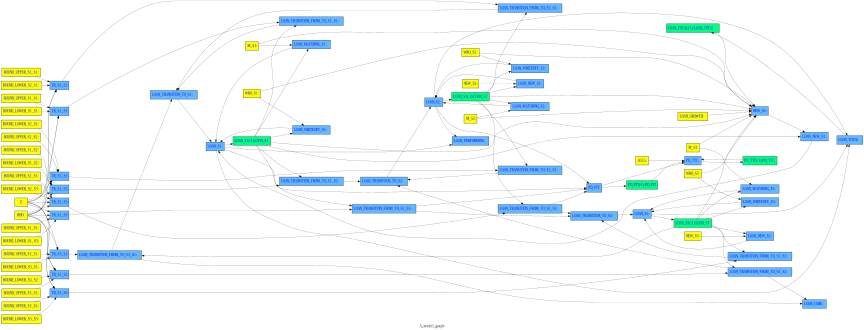

In [5]:
ecl.drawmodel(sink='LOAN_TOTAL',HR=0,pdf=0,att=0,size=(12,12))

## load data
The data is copy-pasted from the excel sheet 
### Load data common for baseline and adverse

In [6]:
%%dataframe T0tr noshow  prefix=TR_  periods=1 melt 
	S1	S2	S3
S1	89%	9%	2%
S2	15%	79%	6%
S3	2%	24%	74%

In [7]:
%%dataframe  startvalues  show  periods=1 
     pd_pit lgd_pit
        1.6%   20%

,PD_PIT,LGD_PIT
index,,
2021,0.02,0.2


In [8]:
%%dataframe  Loan_t0  show periods=1 melt 
S1	S2	S3 total 
loan 500	180	30 710


,S1,S2,S3,TOTAL
LOAN,500.0,180.0,30.0,710.0


var_name,LOAN_S1,LOAN_S2,LOAN_S3,LOAN_TOTAL
index,,,,
2021,500.0,180.0,30.0,710.0


In [9]:
%%dataframe upper_bin prefix=bound_upper_ nshow periods=7 melt 
	S1	S2	S3
S1	10000	-1,34	-2,33
S2	10000	1,08	-1,64
S3	10000	1,88	0,58
 

In [10]:
%%dataframe lower_bin prefix=bound_lower_ show periods=7 melt 
	S1	S2	S3
S1	-1,34	-2,33	-10000
S2	1,08	-1,64	-10000
S3	1,88	0,58	-10000

,S1,S2,S3
S1,-1.34,-2.33,-10000.0
S2,1.08,-1.64,-10000.0
S3,1.88,0.58,-10000.0


var_name,BOUND_LOWER_S1_S1,BOUND_LOWER_S2_S1,BOUND_LOWER_S3_S1,BOUND_LOWER_S1_S2,BOUND_LOWER_S2_S2,BOUND_LOWER_S3_S2,BOUND_LOWER_S1_S3,BOUND_LOWER_S2_S3,BOUND_LOWER_S3_S3
index,,,,,,,,,
2021,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2022,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2023,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2024,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2025,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2026,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0
2027,-1.34,1.08,1.88,-2.33,-1.64,0.58,-10000.0,-10000.0,-10000.0


In [11]:
%%dataframe parameters show periods=7  
rho
0.2

,RHO
index,
2021,0.2
2022,0.2
2023,0.2
2024,0.2
2025,0.2
2026,0.2
2027,0.2


### Create the Static dataframe, common to scenarios

In [12]:
staticdf = pd.concat([T0tr_melted,Loan_t0_melted,startvalues,upper_bin_melted, 
                      lower_bin_melted,parameters],axis=1)
HTML(staticdf.T.style.render().replace('nan',''))

index,2021,2022,2023,2024,2025,2026,2027
TR_S1_S1,0.89,,,,,,
TR_S2_S1,0.15,,,,,,
TR_S3_S1,0.02,,,,,,
TR_S1_S2,0.09,,,,,,
TR_S2_S2,0.79,,,,,,
TR_S3_S2,0.24,,,,,,
TR_S1_S3,0.02,,,,,,
TR_S2_S3,0.06,,,,,,
TR_S3_S3,0.74,,,,,,
LOAN_S1,500.00,,,,,,


### Load data specific for the scenarios

In [13]:
%%dataframe  inf_baseline  nshow t periods=7 melt
    m     wro
s1  5%   0
s2  3.8%   0
s3  0    7.5%

In [14]:
%%dataframe  inf_adverse  nshow t periods=7 melt
    m     wro
s1  3.8%   0
s2  2.5%   0
s3  0    6.3%

In [15]:
%%dataframe projection_baseline nshow
Z  loan_growth
 0          0.01 
-0,47	    0.01   
-0,42	    0.01
-0,38	    0.01
-0,36	    0.01
-0,34	    0.01
-0,33	    0.01

In [16]:
%%dataframe projection_adverse nshow
 Z        loan_growth
 0          0.01
  -0,65     -0.01
  -0,84     -0.008
   -0,99    -0.006
    -0,69   -0.004
    -0,39   -0.002
    -0,24   -0.0

### Create a dataframe for baseline and adverse scenario 

In [17]:
baseupdate    = pd.concat([inf_baseline_melted, projection_baseline],axis=1).pipe(sortdf)
adverseupdate =  pd.concat([inf_adverse_melted, projection_adverse],axis=1).pipe(sortdf)
getnotnul = lambda x: x.loc[:,(x!=0.0).any(axis=0)] 

display(Markdown('## Baseline scenario'))
display(baseupdate.pipe(getnotnul))
display(Markdown('## Adverse scenario'))
display(adverseupdate.pipe(getnotnul))

## Baseline scenario

,LOAN_GROWTH,M_S1,M_S2,WRO_S3,Z
index,,,,,
2021,0.01,0.05,0.04,0.07,0.00
2022,0.01,0.05,0.04,0.07,-0.47
2023,0.01,0.05,0.04,0.07,-0.42
2024,0.01,0.05,0.04,0.07,-0.38
2025,0.01,0.05,0.04,0.07,-0.36
2026,0.01,0.05,0.04,0.07,-0.34
2027,0.01,0.05,0.04,0.07,-0.33


## Adverse scenario

,LOAN_GROWTH,M_S1,M_S2,WRO_S3,Z
index,,,,,
2021,1.00e-02,0.04,0.03,0.06,0.00
2022,-1.00e-02,0.04,0.03,0.06,-0.65
2023,-8.00e-03,0.04,0.03,0.06,-0.84
2024,-6.00e-03,0.04,0.03,0.06,-0.99
2025,-4.00e-03,0.04,0.03,0.06,-0.69
2026,-2.00e-03,0.04,0.03,0.06,-0.39
2027,-0.00e+00,0.04,0.03,0.06,-0.24


In [18]:
baseline = pd.concat([staticdf, inf_baseline_melted, projection_baseline],axis=1)
adverse  = pd.concat([staticdf, inf_adverse_melted, projection_adverse],axis=1)
baseline.index = pd.period_range(start=2021,freq = 'Y',periods=7)
adverse.index  = pd.period_range(start=2021,freq = 'Y',periods=7)

display(baseline.pipe(sortdf).T)

,2021,2022,2023,2024,2025,2026,2027
BOUND_LOWER_S1_S1,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34
BOUND_LOWER_S1_S2,-2.33,-2.33,-2.33,-2.33,-2.33,-2.33,-2.33
BOUND_LOWER_S1_S3,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00
BOUND_LOWER_S2_S1,1.08,1.08,1.08,1.08,1.08,1.08,1.08
BOUND_LOWER_S2_S2,-1.64,-1.64,-1.64,-1.64,-1.64,-1.64,-1.64
BOUND_LOWER_S2_S3,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00
BOUND_LOWER_S3_S1,1.88,1.88,1.88,1.88,1.88,1.88,1.88
BOUND_LOWER_S3_S2,0.58,0.58,0.58,0.58,0.58,0.58,0.58
BOUND_LOWER_S3_S3,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00
BOUND_UPPER_S1_S1,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00


## Run baseline 

In [19]:
base_result  = ecl(baseline,keep='Baseline')

Will start calculating: testmodel
2022  solved
2023  solved
2024  solved
2025  solved
2026  solved
2027  solved
testmodel calculated 


### Save model and baseline results

In [20]:
ecl.modeldump('ecl.pcim')

## Run adverse

In [21]:
adverse_result = ecl(adverse,keep = 'Adverse')

Will start calculating: testmodel
2022  solved
2023  solved
2024  solved
2025  solved
2026  solved
2027  solved
testmodel calculated 


## Inspect Results

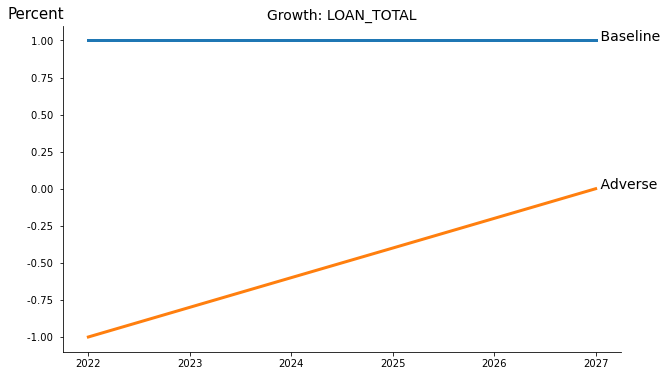

In [22]:
with ecl.set_smpl('2021','2027'):
    ecl.keep_plot('loan_total',showtype='growth',legend=False);

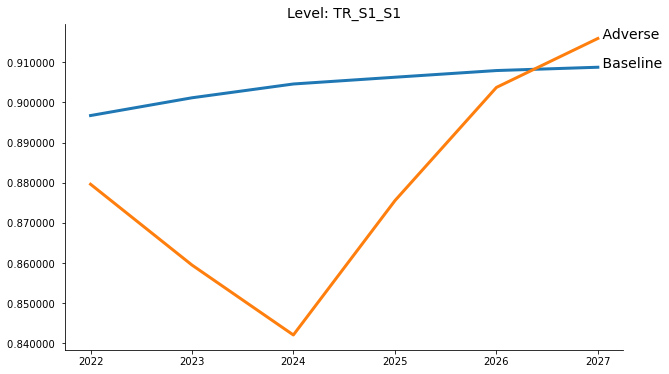

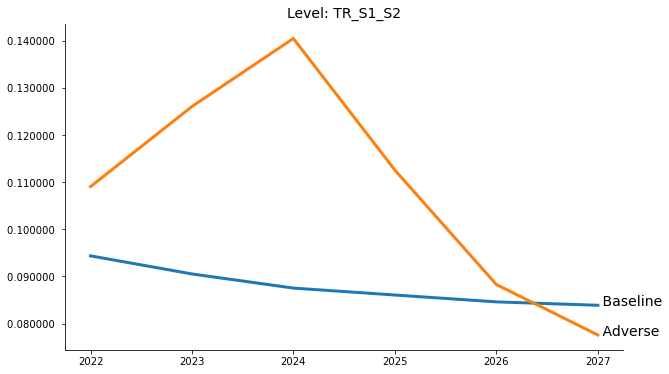

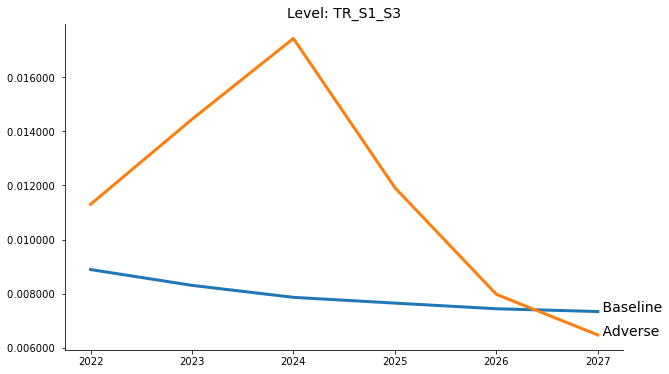

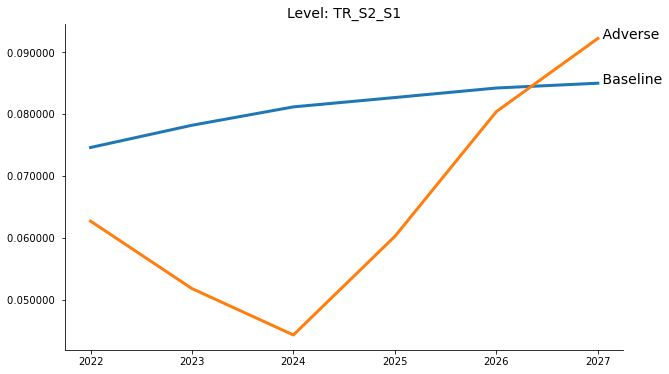

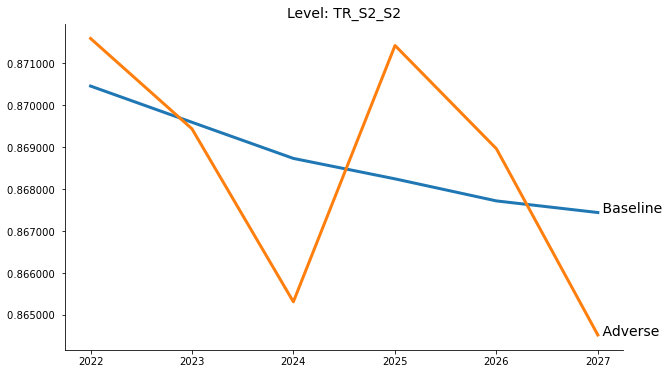

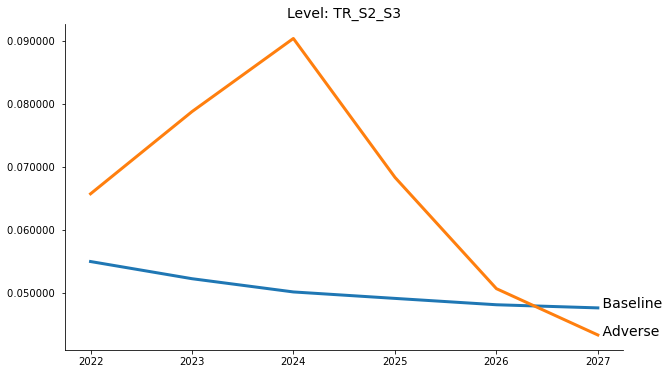

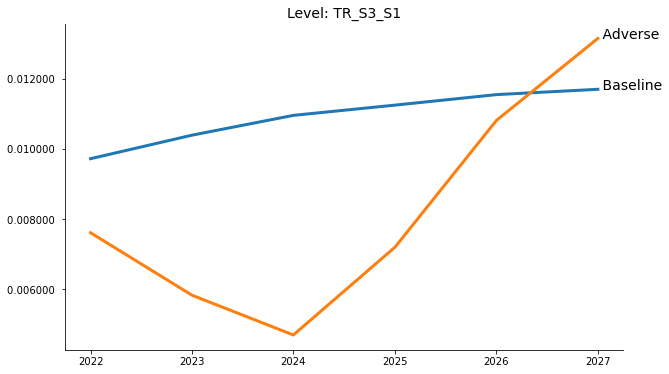

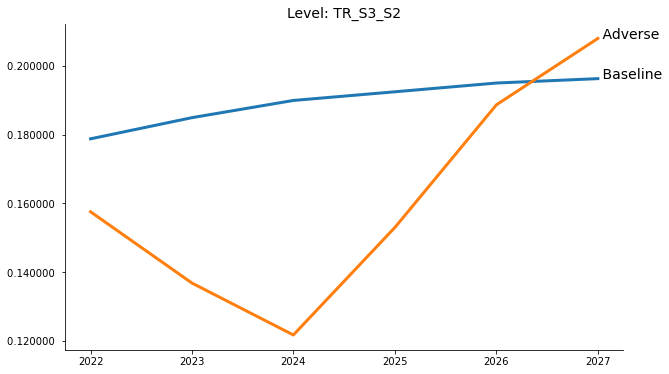

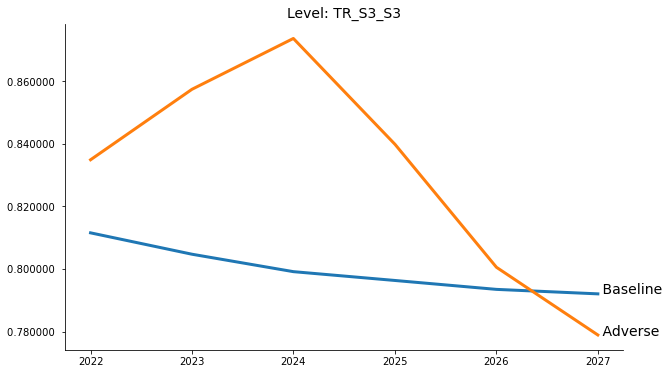

In [23]:
ecl.keep_plot('tr_*',showtype='level',legend=False);

In [24]:
ecl.PD_PIT.tracepre(up=4,HR=1,filter=30,pdf=1)